In [1]:
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf

import nn

nn.enable_debug_eager_mode()
tf.random.set_seed(42)

In [2]:
time_dim = nn.SpatialDim("time")
nn.FeatureDim("in", 5)

Dim{F'in'(5)}

In [3]:
import example_data.audio
raw_audio, out_raw_spatial_dim = example_data.audio.get_sample_batch()  # [B,samples]
raw_audio, out_raw_spatial_dim

Metal device set to: Apple M1 Pro
layer dummy_net/'constant': [B(2),T|'samples'[B(2)]] float32


2022-04-27 01:14:07.532651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 01:14:07.532782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(<Tensor /'constant' [B(2),T|'samples'[B(2)]] via 'constant'>,
 Dim{'samples'[B(2)]})

In [4]:
if False:  # optional
    import soundcard
    speaker = soundcard.default_speaker()

    speaker.play(raw_audio.data.placeholder.numpy()[0], 16_000)


2022-04-27 01:14:07.618344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 01:14:07.618367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


layer dummy_net/'gt_old_style_raw_samples_input': [B(2),T|'samples'[B(2)],F|F'dummy-feat-dim'(1)] float32
layer dummy_net/gt_old_style_wrapped/'shift_1_raw': [B(2),T|'-1+samples'[?],F|F'dummy-feat-dim'(1)] float32
layer dummy_net/gt_old_style_wrapped/'shift_0': [B(2),T|'samples+-1'[?],F|F'dummy-feat-dim'(1)] float32
layer dummy_net/gt_old_style_wrapped/'shift_1': [B(2),T|'samples+-1'[B(2)],F|F'dummy-feat-dim'(1)] float32
layer dummy_net/gt_old_style_wrapped/'preemphasis': [B(2),T|'samples+-1'[B(2)],F|F'dummy-feat-dim'(1)] float32
setup_tf_thread_pools() not yet called (via func get_tf_list_local_devices), calling it now.
Setup TF inter and intra global thread pools, num_threads None, session opts {'log_device_placement': False, 'device_count': {'GPU': 0}}.
Device not set explicitly, and we found a GPU, which we will use.
layer dummy_net/gt_old_style_wrapped/'gammatone_filterbank': [B(2),F|F'gammatone_filterbank:channel'(50),T|'gammatone_filterbank:conv:s0'[?]] float32
layer dummy_net/g

(<Tensor /'gt_old_style_set_dims' [B(2),T|'time'[B(2)],F|F'channels'(50)] via 'reinterpret_data'>,
 Dim{'time'[?]},
 <tf.Tensor: shape=(2, 1423, 50), dtype=float32, numpy=
 array([[[-2.29748631e+00, -4.50629741e-03,  5.52430630e-01, ...,
           3.83016646e-01, -1.31337401e-02, -2.02058986e-01],
         [-2.21379805e+00,  1.89192186e-03,  2.22585917e-01, ...,
           6.51689649e-01,  2.68675983e-01,  8.23900878e-01],
         [-2.17981553e+00, -1.88614912e-02,  3.00244629e-01, ...,
          -2.06582174e-01, -9.99456882e-01,  3.00686210e-01],
         ...,
         [-2.32931876e+00,  1.01233594e-01,  5.08740902e-01, ...,
          -5.96425533e-01, -1.04891837e+00, -8.46800447e-01],
         [-2.39032054e+00, -7.35807791e-02,  4.90915477e-01, ...,
          -3.49867553e-01, -6.88834727e-01,  2.21754566e-01],
         [-2.44923496e+00, -1.11007869e-01,  5.23514688e-01, ...,
           1.07335639e+00,  1.09195709e+00, -4.00692850e-01]],
 
        [[-1.04700589e+00,  1.12054832e-01,

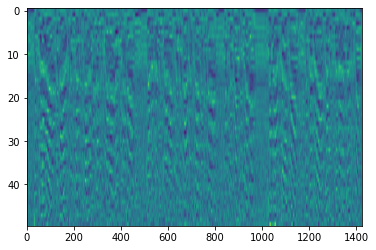

In [5]:
import asr.gt
audio, out_spatial_dim = asr.gt.wrapped_old_style(raw_audio, normalization="time")
# audio = nn.BatchNorm(use_mask=True)(audio)
audio, out_spatial_dim, audio.data.placeholder, imshow(audio.data.placeholder.numpy()[0].transpose(), aspect="auto")

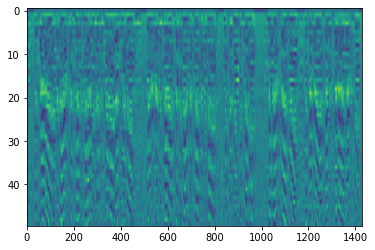

In [6]:
sample_rate = 16_000
stfts = tf.signal.stft(
    raw_audio.data.placeholder, frame_length=int(0.025 * sample_rate), frame_step=int(0.01 * sample_rate))
spectrograms = tf.abs(stfts) ** 2.

num_spectrogram_bins = stfts.shape[-1].value
lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0.0, sample_rate / 2, 128
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
  num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

# Compute a stabilized log to get log-magnitude mel-scale spectrograms.
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

# Compute MFCCs from log_mel_spectrograms and take the first num_mel_bins.
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :50]

mfccs = tf.math.l2_normalize(mfccs, axis=1)

imshow(mfccs.numpy()[0].transpose(), aspect="auto")

layer dummy_net/'specaugment': [B(2),T|'time'[B(2)],F|F'channels'(50)] float32


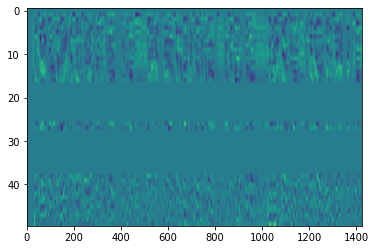

In [7]:
from asr.specaugment import specaugment_v1
masked = specaugment_v1(audio, global_train_step_dependent=False)
imshow(masked.data.placeholder.numpy()[0].transpose(), aspect="auto")